# Structure

- ✔ **Factoid**: How many raids does an area have?
- ✔ **Comparison**: Which areas have the most raids?
- ✔ **Trend**: Is there a clear increase/decrease over time?
- ✔ **Interaction**: Why are there more raids in some places than others? (e.g. ethnicity)
- ✔ Map - **find yourself**

### Background

We put in Freedom Of Information (FOI) requests to the Home Office, to detail raids over the last few years. We managed to get back how many immigration raids have happened, broken down by year and by first bit of the postcode (e.g. N15, E6).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as mtick
from matplotlib.colors import Normalize as nlz
import seaborn as sns
import numpy as np

first_yr = 2014
last_yr = 2022
yr_range = str(first_yr) + '-' + str(last_yr)

In [2]:
plt.rcParams['figure.figsize'] = (15, 11)
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.edgecolor'] = '#A9A9A9'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['savefig.transparent'] = True

watermark_str = "Data from Anti-Raids Network FOIs, covering London from {}. More at https://antiraids.github.io"
watermark_str = watermark_str.format(yr_range)
red = '#d62728'
brown = '#8c564b'

### Are there more raids in some areas than others?

In [3]:
raids_by_year = pd.read_csv('AmendedData\\LondonRaidsByYear.csv', index_col=["PostDist"])
full_yrs = [str(yr) for yr in range(first_yr, last_yr+1)]
raids_by_year = raids_by_year[full_yrs]
raids_by_year.loc[:,'Total'] = raids_by_year.sum(axis=1)
# print(raids_by_year)
print('How many districts:',len(raids_by_year))

How many districts: 169


The spread of immigration raids is quite uneven. If you look at how many districts have 0-99 raids, 100-199 raids, etc. it's most common for districts to have less than 100 raids...

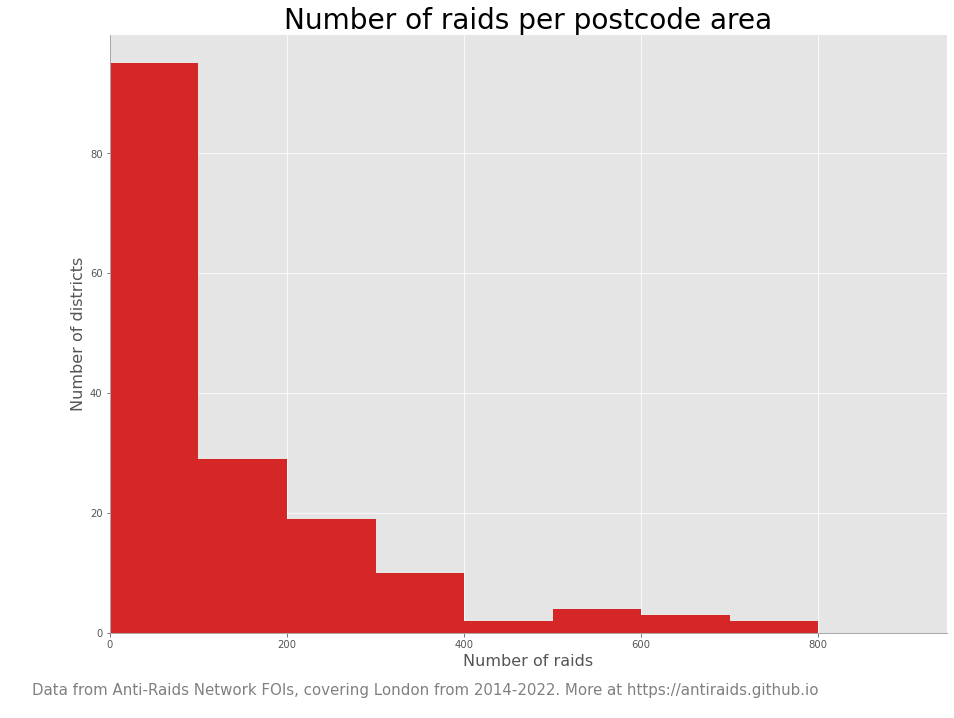

In [4]:
raids_by_year['Total'].plot.hist(bins=[100*n for n in range(10)], color=red)
plt.title('Number of raids per postcode area')
plt.xlabel('Number of raids')
plt.ylabel('Number of districts')
plt.xlim(0)
plt.annotate(watermark_str, (0.03, 0.03), color='grey', fontsize=15, xycoords='figure fraction')
plt.savefig('Outputs\\Raids_totals_hist.png')

...but overall, about 1 in 5 London districts have had 200+ raids over the last few years.

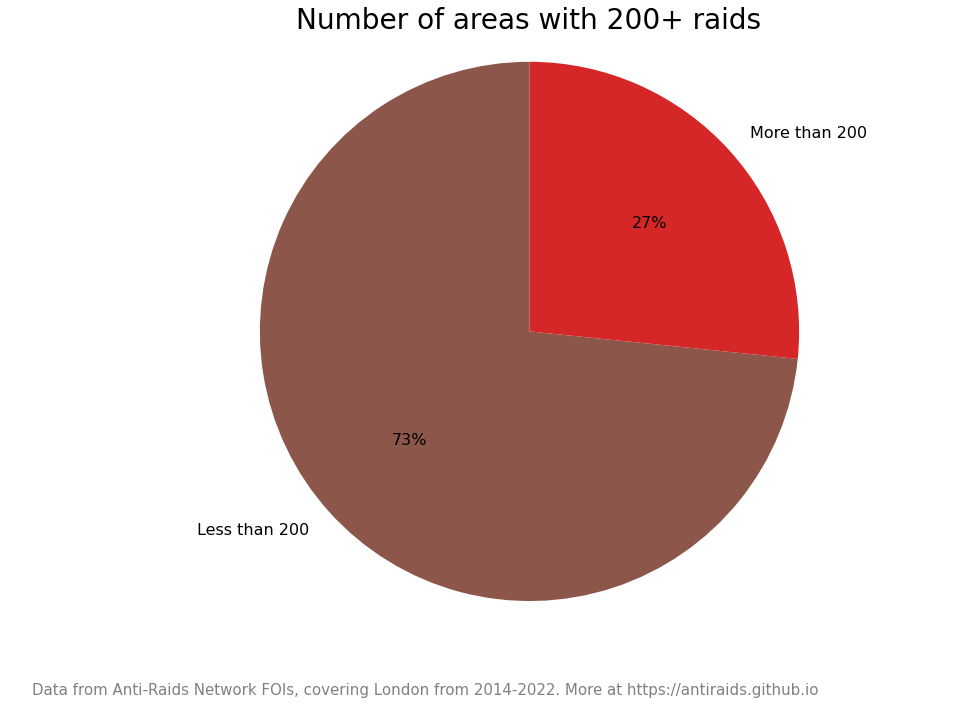

In [5]:
cutoff = 200
str_cutoff = str(cutoff)
labels = ['Less than '+str_cutoff, 'More than '+str_cutoff]
sizes = [len(raids_by_year['Total'][raids_by_year['Total'] < cutoff])]
sizes += [len(raids_by_year['Total'][raids_by_year['Total'] >= cutoff])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=[brown, red],
       textprops=dict(size=16))
ax1.axis('equal')
ax1.set_title('Number of areas with ' + str_cutoff + '+ raids')
plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
plt.savefig('Outputs\\Raids_totals_pie.png')
plt.show()

### Where are there the most raids?

There is no obvious "huge outlier", where there are loads more raids happening in one specific district. For example, you could look at the top 5 districts for number of raids:

In [6]:
raids_by_year.sort_values('Total', ascending=False).head(5)

,2014,2015,2016,2017,2018,2019,2020,2021,2022,Total
PostDist,,,,,,,,,,
E6,328.0,219.0,209.0,204.0,157.0,83.0,22.0,26.0,18.0,1266.0
E7,224.0,204.0,186.0,165.0,121.0,76.0,21.0,20.0,14.0,1031.0
SE1,87.0,137.0,214.0,279.0,160.0,58.0,20.0,14.0,3.0,972.0
SE18,177.0,219.0,166.0,121.0,78.0,76.0,26.0,18.0,35.0,916.0
E17,148.0,138.0,92.0,103.0,161.0,153.0,60.0,33.0,16.0,904.0


But it's skewed because some districts are bigger than others. In general, the more people in a district, the more raids there are in that district.

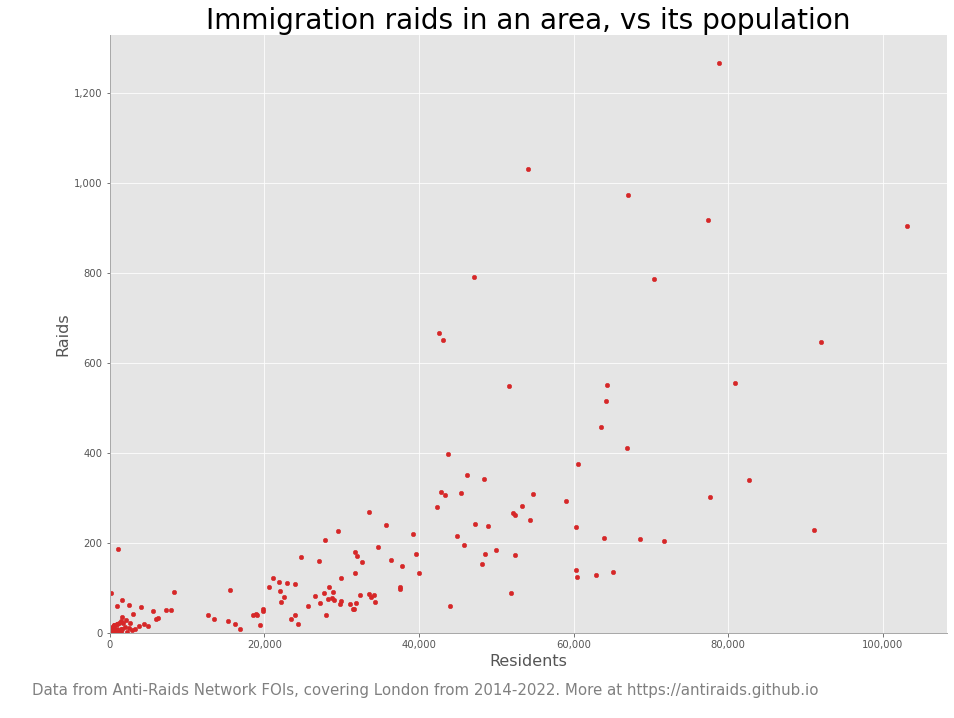

In [7]:
raid_popn = pd.read_csv('AmendedData\\PopnRaidsRate.csv', index_col=['Postcode'])
# print(raid_popn)
ax = raid_popn.plot.scatter('Residents', 'Count', color=red)
plt.title('Immigration raids in an area, vs its population')
plt.ylabel('Raids')
plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
plt.xlim(0)
plt.ylim(0)
thou_fmt = mtick.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(thou_fmt)
ax.yaxis.set_major_formatter(thou_fmt)
plt.savefig('Outputs\\Raids_vs_residents.png')
# raid_popn.corr().loc['Count', 'Residents'] ~= 0.7

One question to consider: **where are there the "most" raids?**

What's most relevant to us as a network are districts that have both a high _number_ and a high _rate_ of raids.

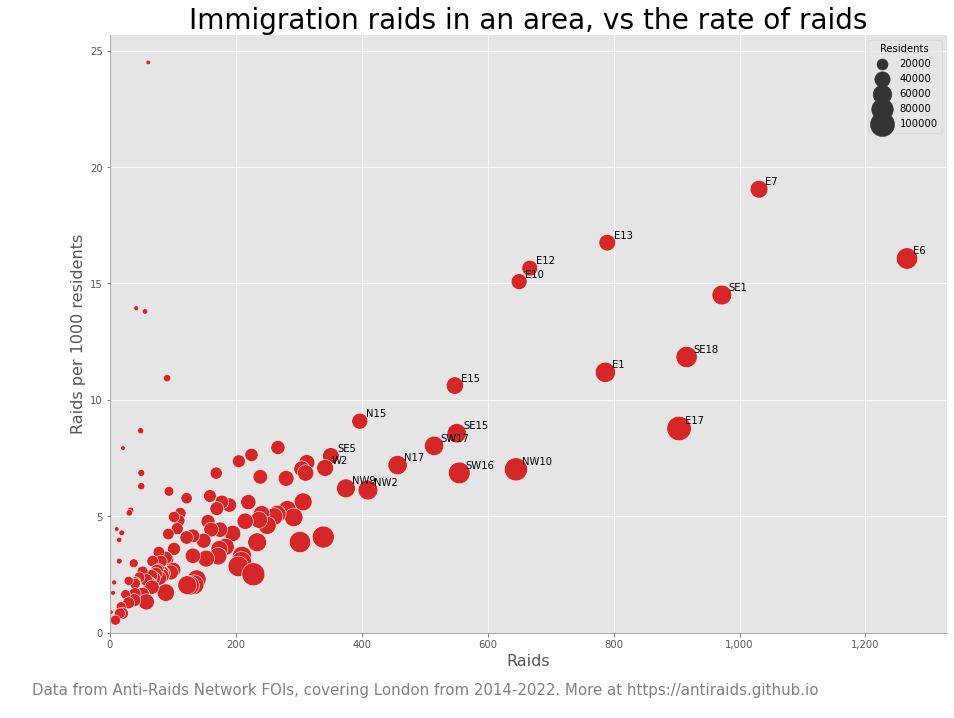

In [8]:
# Add count/rate ranking
raid_popn['Scale'] = raid_popn['Count'] * raid_popn['Rate']

# Remove the lowest population districts, to avoid skewing the axes
not_low_pop = raid_popn[raid_popn.Residents > raid_popn['Residents'].quantile(0.2)]
not_low_pop = not_low_pop.sort_values('Scale', ascending=False)

# Scatterplot!
ax = sns.scatterplot(x="Count", y="Rate", size="Residents", sizes=(20, 600), data=not_low_pop, color=red)
plt.title('Comparing number of raids and rate of raids')
plt.title('Immigration raids in an area, vs the rate of raids')
plt.ylabel('Raids per 1000 residents')
plt.xlabel('Raids')
# Label only the high points, to avoid bottom-left getting very messy
to_number = 20
for line in range(to_number):
     ax.text(not_low_pop.Count[line]+10, not_low_pop.Rate[line]+0.2, 
     not_low_pop.index[line], horizontalalignment='left', 
     size='medium', color='black')

plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
plt.xlim(0)
plt.ylim(0)
ax.xaxis.set_major_formatter(thou_fmt)
plt.savefig('Outputs\\Raids_vs_rate.png')

It's possible to also look at

- high raids/low population districts
- high population/low raids districts

But have skipped those ones - all higher raid areas have reasonably high populations, and though the high population/low raid count areas could give meaning, it'd be really hard to draw it out without substantial local knowledge and a lot more investigation.

### Why are there more raids in some places than others?

Is it POC-related?

In [9]:
by_ethnicity = pd.read_csv('AmendedData\\PostcodeEthnicityRates_toplevel.csv', index_col=0)
by_ethnicity = by_ethnicity[['nonwhite_rate']]
raid_rate_ethnicity = raid_popn.join(by_ethnicity)
raid_rate_ethnicity.head()

,Residents,Count,Rate,Scale,nonwhite_rate
Postcode,,,,,
E1,70389.0,787.0,11.180724,8799.229993,0.620935
E10,43120.0,650.0,15.074212,9798.237477,0.613010
E11,54689.0,307.0,5.613560,1723.363016,0.453162
E12,42606.0,667.0,15.655072,10441.933061,0.804605
E13,47169.0,790.0,16.748288,13231.147576,0.708092


Correlation coefficient: 0.63


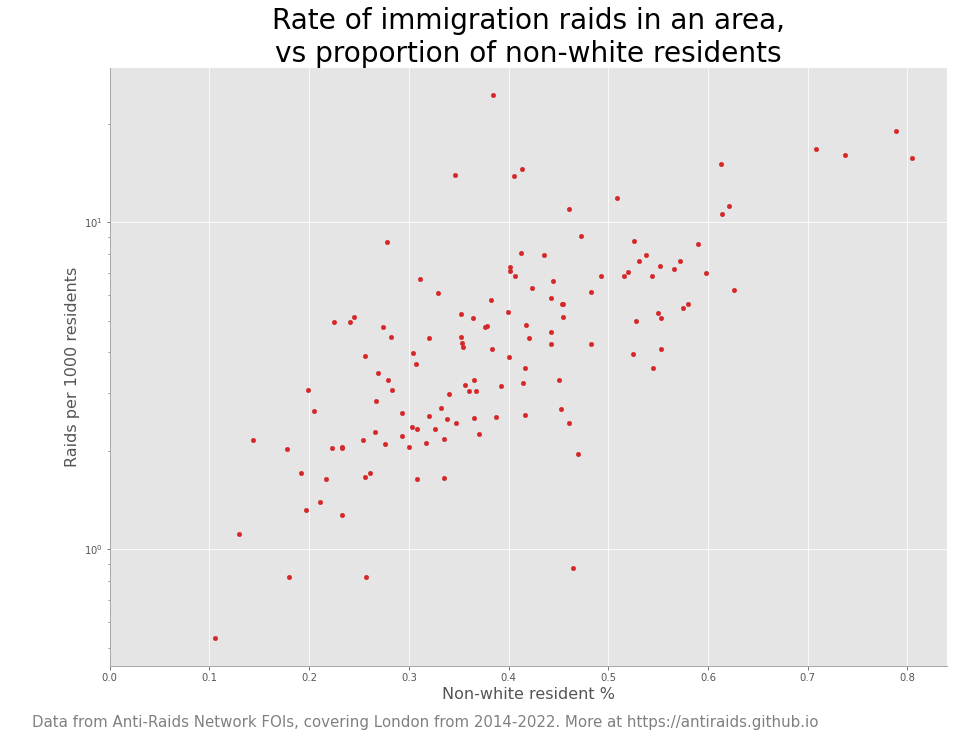

In [10]:
raid_eth_nonlow = raid_rate_ethnicity
raid_eth_nonlow = raid_eth_nonlow[raid_eth_nonlow['Residents'] > raid_eth_nonlow['Residents'].quantile(0.2)]
raid_eth_nonlow.plot.scatter('nonwhite_rate', 'Rate', color=red)
plt.title('Rate of immigration raids in an area,\nvs proportion of non-white residents')
plt.ylabel('Raids per 1000 residents')
plt.xlabel('Non-white resident %')
plt.yscale('log')
plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
plt.xlim(0)
print('Correlation coefficient: {:.2f}'.format(raid_eth_nonlow.corr().loc['nonwhite_rate', 'Rate']))

All the higher POC postcode districts have a high rate of raids!

Including the size of the area...

In [11]:
raid_eth_nonlow.loc[:, 'Scale'] = raid_eth_nonlow['Rate'] * raid_eth_nonlow['nonwhite_rate']
raid_eth_nonlow = raid_eth_nonlow.sort_values('Scale', ascending=False)
raid_eth_nonlow.head()

C:\Users\setat\Anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Residents,Count,Rate,Scale,nonwhite_rate
Postcode,,,,,
E7,54133.0,1031.0,19.045684,15.018271,0.788539
E12,42606.0,667.0,15.655072,12.596149,0.804605
E13,47169.0,790.0,16.748288,11.859332,0.708092
E6,78790.0,1266.0,16.068029,11.856570,0.737898
WC2H,2491.0,61.0,24.488157,9.407935,0.384183


In [12]:
raid_eth_nonlow.describe()

,Residents,Count,Rate,Scale,nonwhite_rate
count,131.000000,131.000000,131.000000,131.000000,131.000000
mean,36766.061069,203.152672,5.181750,2.363514,0.390821
std,21848.514336,231.771621,3.978407,2.566942,0.135352
min,2282.000000,2.000000,0.534759,0.056399,0.105466
25%,22072.000000,58.000000,2.467760,0.793520,0.293163
50%,32684.000000,122.000000,4.232275,1.495465,0.378655
75%,50796.500000,245.500000,6.656131,2.935617,0.466992
max,103129.000000,1266.000000,24.488157,15.018271,0.804605


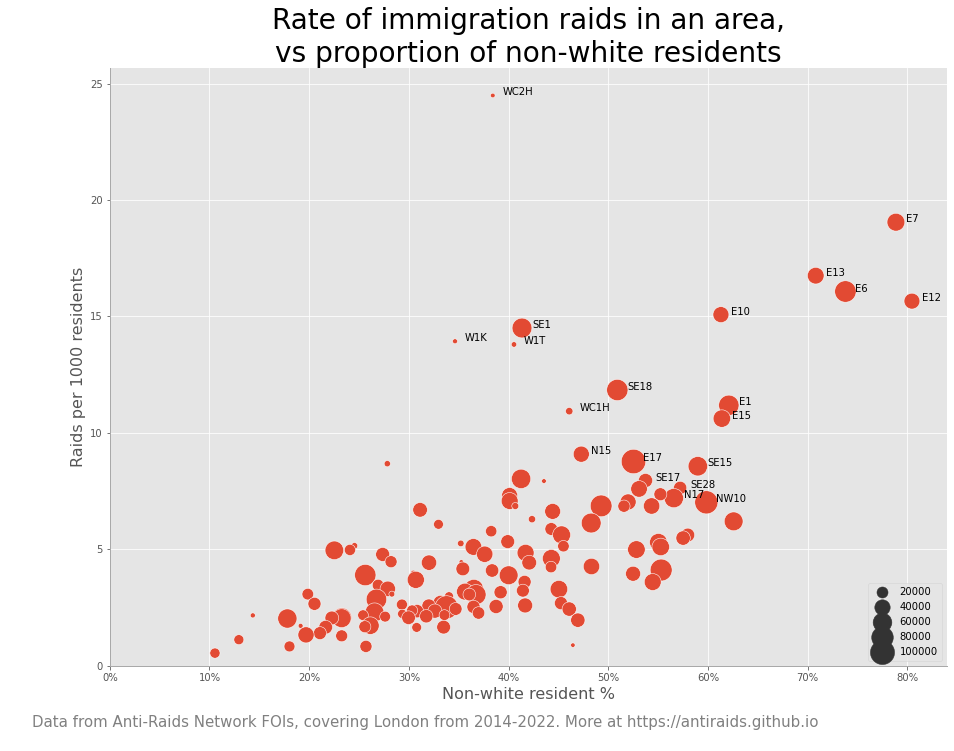

In [13]:
# Scatterplot!
ax = sns.scatterplot(x="nonwhite_rate", y="Rate", size="Residents", sizes=(20, 600), data=raid_eth_nonlow)
plt.title('Rate of immigration raids in an area,\nvs proportion of non-white residents')
plt.ylabel('Raids per 1000 residents')
plt.xlabel('Non-white resident %')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
# Label only the high points, to avoid bottom-left getting very messy
to_number = 20
for line in range(to_number):
     ax.text(raid_eth_nonlow['nonwhite_rate'][line]+0.01, raid_eth_nonlow['Rate'][line],
             raid_eth_nonlow.index[line], horizontalalignment='left',
             size='medium', color='black')
plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
plt.xlim(0)
plt.ylim(0)
plt.legend(loc='lower right')
plt.savefig('Outputs\\RaidsRate_vs_nonwhite.png')

In [14]:
by_ethnicity_checks = pd.read_csv('AmendedData\\PostcodeEthnicityRates_keylines.csv', index_col=0)
raids_ethnicity_checks = raid_popn.join(by_ethnicity_checks)

In [15]:
ethnicity_checks = raids_ethnicity_checks.loc[:, 'Other White':].columns
for eth in ethnicity_checks:
    raids_ethnicity_checks[eth] = raids_ethnicity_checks[eth] / raids_ethnicity_checks['total']
raids_ethnicity_checks.head()

,Residents,Count,Rate,Scale,total,Other White,Indian,Pakistani,Bangladeshi,Chinese,Other Asian,African,Caribbean,Other Black,Arab
Postcode,,,,,,,,,,,,,,,
E1,70389.0,787.0,11.180724,8799.229993,70389.0,0.118598,0.021026,0.014349,0.425919,0.020912,0.023555,0.031369,0.013710,0.012573,0.012431
E10,43120.0,650.0,15.074212,9798.237477,43120.0,0.177922,0.047426,0.155844,0.026739,0.014193,0.052690,0.090631,0.093854,0.034949,0.016558
E11,54689.0,307.0,5.613560,1723.363016,54689.0,0.151456,0.062151,0.073616,0.027428,0.012525,0.034358,0.067143,0.063815,0.021375,0.015286
E12,42606.0,667.0,15.655072,10441.933061,42606.0,0.061635,0.207201,0.140168,0.166338,0.002676,0.067807,0.088485,0.044900,0.018941,0.009459
E13,47169.0,790.0,16.748288,13231.147576,47169.0,0.112320,0.102970,0.088130,0.139074,0.008523,0.067587,0.141534,0.052238,0.027624,0.009561


In [16]:
raids_ethnicity_checks = raids_ethnicity_checks[raids_ethnicity_checks['Residents'] > raids_ethnicity_checks['Residents'].quantile(0.2)]

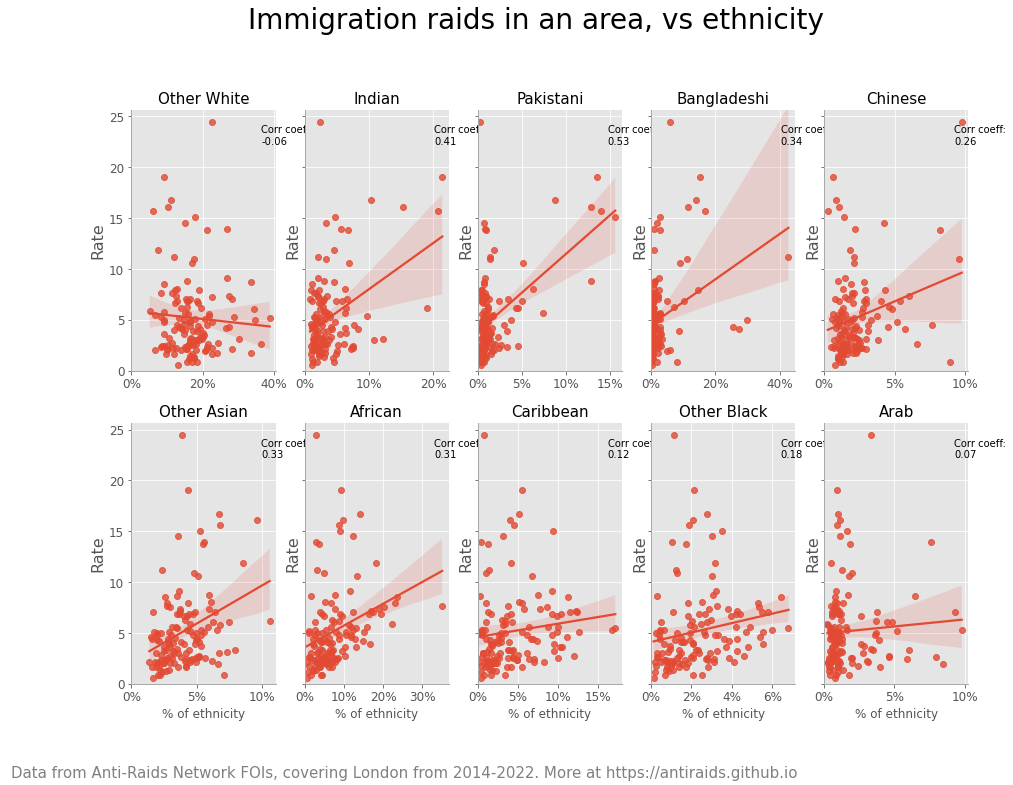

In [17]:
figeth, axeth = plt.subplots(2, 5, sharey=True)
for i, (ax, eth) in enumerate(zip(axeth.flatten(), ethnicity_checks)):
    # ax.scatter(raids_ethnicity_checks[eth], raids_ethnicity_checks['Count'])
    sns.regplot(x=eth, y='Rate', data=raids_ethnicity_checks, fit_reg=True, ax=ax)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_title(eth, fontsize=15)
    if i>=5:
        ax.set_xlabel('% of ethnicity')
    else:
        ax.set_xlabel('')
    corr_coeff = raids_ethnicity_checks.corr().loc[eth, 'Rate']
    ax.text(0.9, 0.9, 'Corr coeff:\n{:.2f}'.format(corr_coeff), horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.xaxis.label.set_size(12)

plt.annotate(watermark_str, (0.01, 0.01), xycoords='figure fraction', color='grey', fontsize=15)
# plt.tight_layout()
plt.suptitle('Immigration raids in an area, vs ethnicity', fontsize=28)
plt.subplots_adjust(top=0.85)
plt.savefig('Outputs\\RaidsByEthnicity.png')

### Are there more or less raids now than in 2014?

Before the pandemic, there wasn't a clear pattern of increase or decrease over the last few years. Some boroughs went up, some went down, some were all over the shop. At least, there wasn't evidence of an upward trend since 2014. About as many boroughs went up as went down.

But the main update is that raids have **plummeted** during the pandemic years of 2020-2022.

Text(0.03, 0.03, 'Data from Anti-Raids Network FOIs, covering London from 2014-2022. More at https://antiraids.github.io')

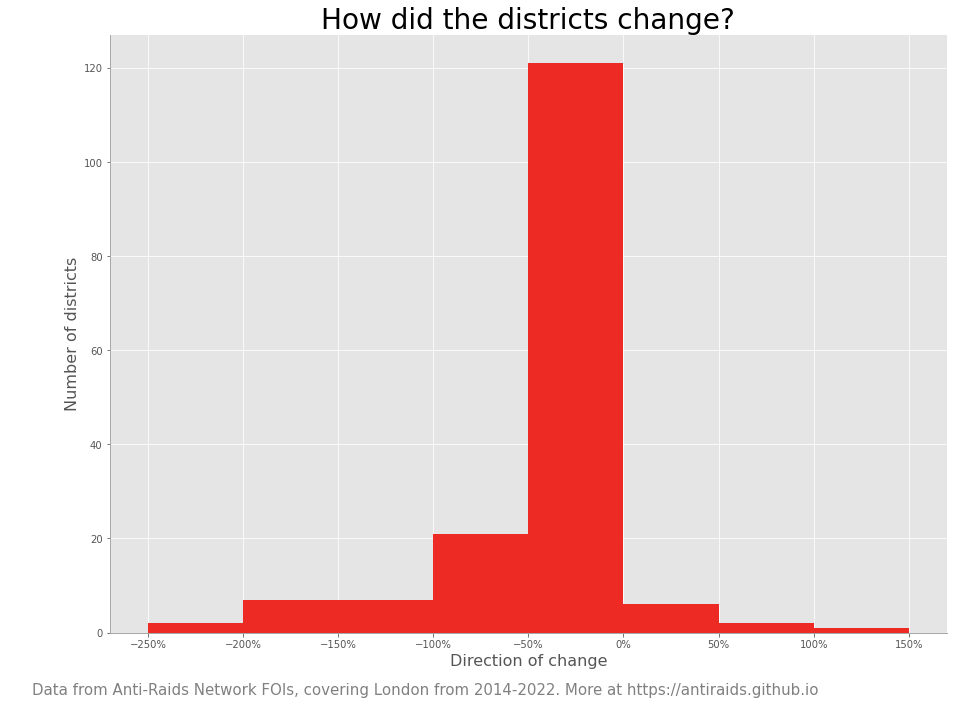

In [18]:
raid_trend = pd.read_csv('AmendedData\\RaidTrends.csv', index_col=0)
raid_trend['trend'] = raid_trend['trend'] * 100
rt = raid_trend.plot.hist(legend=False, color='#ee2a24', bins=range(-250, 200, 50))
rt.set_title('How did the districts change?')
rt.set_xlabel('Direction of change')
rt.set_ylabel('Number of districts')
rt.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.annotate(watermark_str, (0.03, 0.03), xycoords='figure fraction', color='grey', fontsize=15)
# print(raid_trend)

If we look at trends...

In [19]:
# Get tidy raid data
raids = pd.read_csv('AmendedData\\TotalLondonRaidsByYear.csv', index_col=0)
raids = raids[raids['Year'] <= last_yr]
raid_total = raids.groupby('Postcode').sum().drop('Year', axis=1)

In [20]:
# Get rate of change data
min_cap = 50
nonsmall_pcs = list(raid_total[raid_total['Count']>=min_cap].index)
rate_change = raids[raids['Postcode'].isin(nonsmall_pcs)].set_index('Postcode')
rate_change['Change'] = np.nan
for pc in nonsmall_pcs:
    for yr in range(first_yr,last_yr+1):
        yr1 = rate_change.loc[rate_change['Year'] == first_yr]['Count'].loc[pc]
        change = ((rate_change.loc[pc]['Count'] / yr1)*100).tolist()
        rate_change.loc[pc] = rate_change.loc[pc].assign(Change = change)
        total = rate_change.groupby('Postcode').sum().loc[pc, 'Count']
        rate_change.loc[pc, 'Total'] = total

Text(0.5, 1.0, '% change in raids, per postcode district')

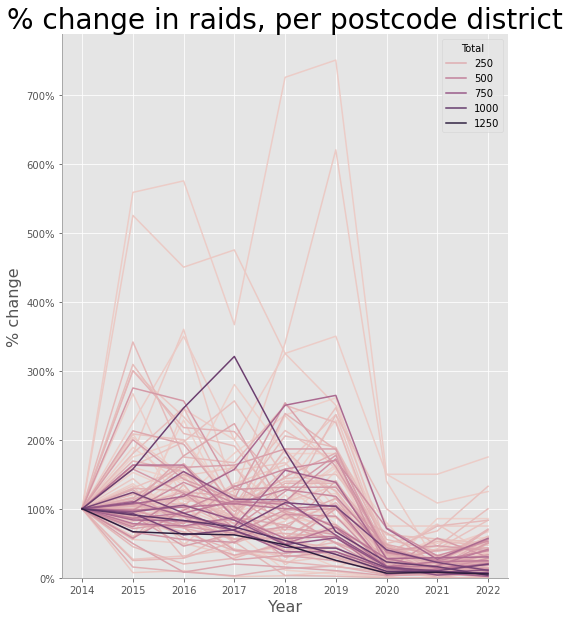

In [21]:
# Spaghetti plot, baby
figspag, axspag = plt.subplots(figsize=(8,10))
sns.lineplot(x='Year',
             y='Change',
             hue='Total',
             ci=None,
#             legend=False,
             data=rate_change.reset_index(),
             ax=axspag
             )
axspag.set_xticks(range(first_yr, last_yr+1))
axspag.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
axspag.set_ylim(0)
axspag.set_ylabel('% change')
axspag.set_title("% change in raids, per postcode district")

Try seeing if we can split this up in any meaningful ways

In [22]:
# Get quantile breaks
change_bdry = {0.25: '', 0.5: '', 0.75: '', 1: ''}
for q in change_bdry.keys():
    change_bdry[q] = rate_change.loc[rate_change['Year'] == last_yr]['Change'].quantile(q)
# print(change_bdry)

# Bin the 2018 change vals into quartiles
rate_quantiles = rate_change.loc[rate_change['Year'] == last_yr]
bins = [0]+list(change_bdry.values())
names = list(change_bdry.keys())
rate_quantiles.loc[:, 'Q'] = pd.cut(rate_quantiles.loc[:, 'Total'], bins, labels=names)
# print(rate_quantiles)
# rate_quantiles.groupby('Q').count()
rate_change = rate_change.join(rate_quantiles.loc[:, 'Q'])
rate_change.loc[:, 'Q'] = pd.to_numeric(rate_change.loc[:, 'Q'])

C:\Users\setat\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


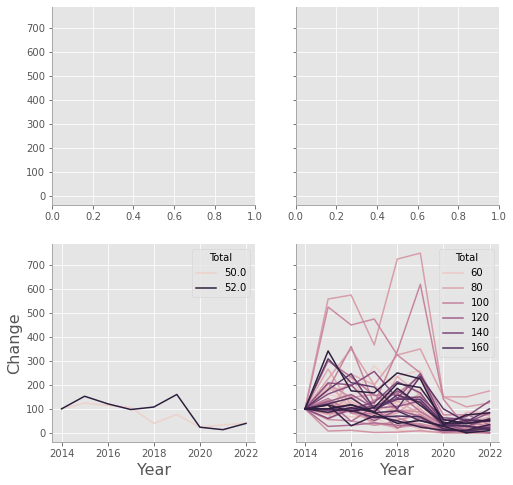

In [23]:
f, ax = plt.subplots(2, 2, sharey=True, figsize=(8,8))
for a,k in zip(ax.reshape(-1),list(change_bdry.keys())):
#   a.plot(rate_change[rate_change['Q'] == k]['Year'], rate_change[rate_change['Q'] == k]['Change'])
    sns.lineplot(x='Year',
                 y='Change',
                 hue='Total',
                 # legend=None,
                 ci=None,
                 data=rate_change[rate_change['Q'] == k].reset_index(),
                 ax=a
                )

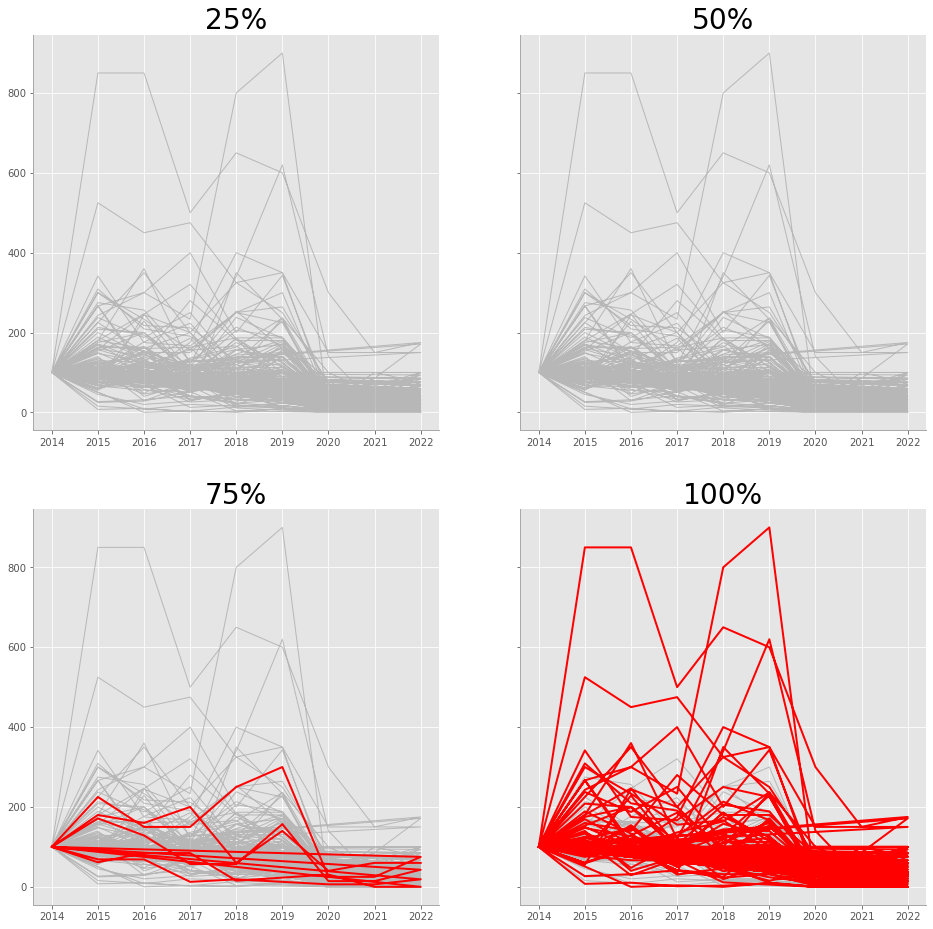

In [24]:
f, ax = plt.subplots(2, 2, sharey=True, figsize=(16,16))
for a,k in zip(ax.reshape(-1),list(change_bdry.keys())):
    a.plot(rate_change[rate_change['Q'] != k]['Year'], rate_change[rate_change['Q'] != k]['Change'],
           color='#8b8b8b', lw='1', alpha=0.5)
    a.plot(rate_change[rate_change['Q'] == k]['Year'], rate_change[rate_change['Q'] == k]['Change'], color='r', lw='2')
    a.set_title('%.0f%%' % (k*100))

Lol, nope, not really. Tried a few ways, and it's messy and too populated.

Don't like that it's anchored at 100% -- maybe do absolute numbers, as it's hard to have an event +/- scale with relative numbers?

In [25]:
raids_abschange = raids.set_index('Postcode')
raids_abschange.sample(5)

,Year,Count
Postcode,,
N7,2021,5.0
N10,2019,15.0
SE17,2020,15.0
SW5,2020,3.0
SW8,2021,2.0


In [26]:
for pc in raid_total.index:
# for pc in ['E8', 'E9', 'N15', 'N17']:
    slc = raids_abschange.loc[pc]
    slc.loc[:, 'Count'] = slc.loc[:, 'Count'] - slc.loc[slc['Year']==first_yr]['Count']
    raids_abschange.loc[pc] = slc
print(raids_abschange.loc[raids_abschange.index=='E9'])

C:\Users\setat\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


          Year  Count
Postcode             
E9        2014    0.0
E9        2015   12.0
E9        2016   22.0
E9        2017    0.0
E9        2018    6.0
E9        2019    6.0
E9        2020   -9.0
E9        2021  -11.0
E9        2022  -12.0


In [27]:
raids_counts = raids_abschange.groupby('Postcode').sum().rename(columns={'Count': 'Total'})[['Total']]
raids_abschange = raids_abschange.join(raids_counts)
raids_abschange.loc[raids_abschange.index=='E9']

,Year,Count,Total
Postcode,,,
E9,2014,0.0,14.0
E9,2015,12.0,14.0
E9,2016,22.0,14.0
E9,2017,0.0,14.0
E9,2018,6.0,14.0
E9,2019,6.0,14.0
E9,2020,-9.0,14.0
E9,2021,-11.0,14.0
E9,2022,-12.0,14.0


In [28]:
raid_total.head()

,Count
Postcode,
E1,787.0
E10,650.0
E11,307.0
E12,667.0
E13,790.0


In [29]:
assert len(raids_abschange[(raids_abschange['Year']==2014) & (raids_abschange['Count']>0)]) == 0

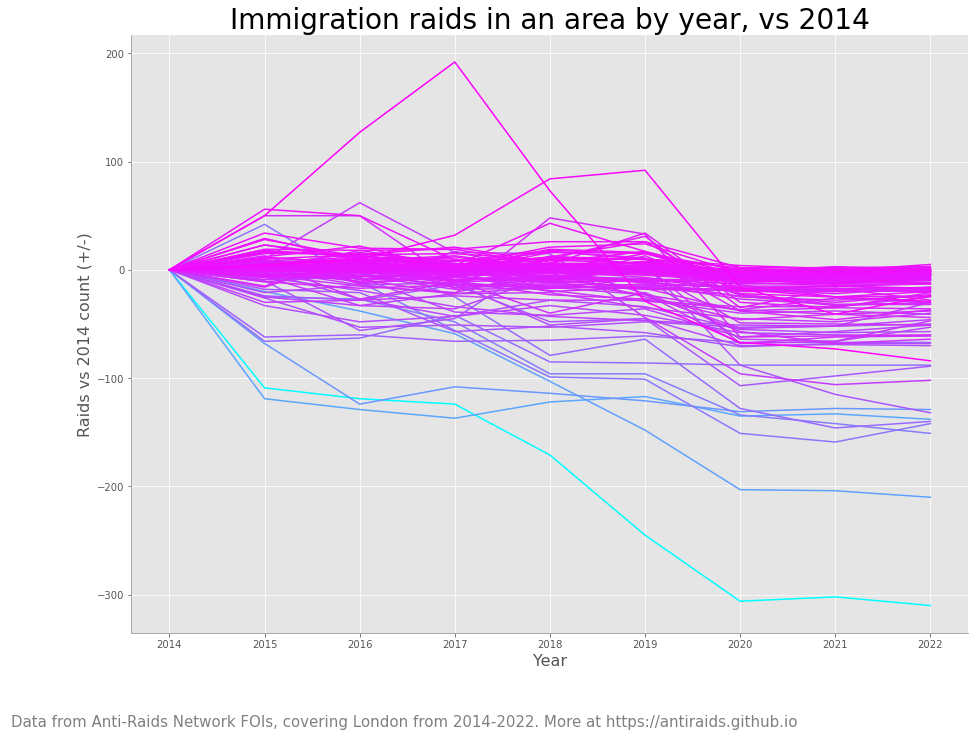

In [30]:
figspag, axspag = plt.subplots()
sns.lineplot(x='Year',
             y='Count',
             ci=None,
             hue='Total',
             legend=False,
             data=raids_abschange.reset_index(),
             ax=axspag,
             palette='cool'
             )
axspag.set_xticks(range(first_yr, last_yr+1))
axspag.set_ylabel('Raids vs 2014 count (+/-)')
axspag.set_title("Immigration raids in an area by year, vs 2014")

plt.annotate(watermark_str, (0.01, 0.01), xycoords='figure fraction', color='grey', fontsize=15)
plt.savefig('Outputs\\Raids_change.png')

This works! Mostly the raids didn't change much over time, until the precipitous drop in 2020-21. N.B. 2014 is a relatively arbitrary baseline year. Not sure this shows the fact there's a drop that well though?

Maybe try breaking down by '800-1200 raids', '400-800 raids' etc?

In [31]:
for df in [raids, raid_total]:
    print(df.head())

  Postcode  Year  Count
0       N1  2014   41.0
1       N1  2015   44.0
2       N1  2016   36.0
3       N1  2017   23.0
4       N1  2018   24.0
          Count
Postcode       
E1        787.0
E10       650.0
E11       307.0
E12       667.0
E13       790.0


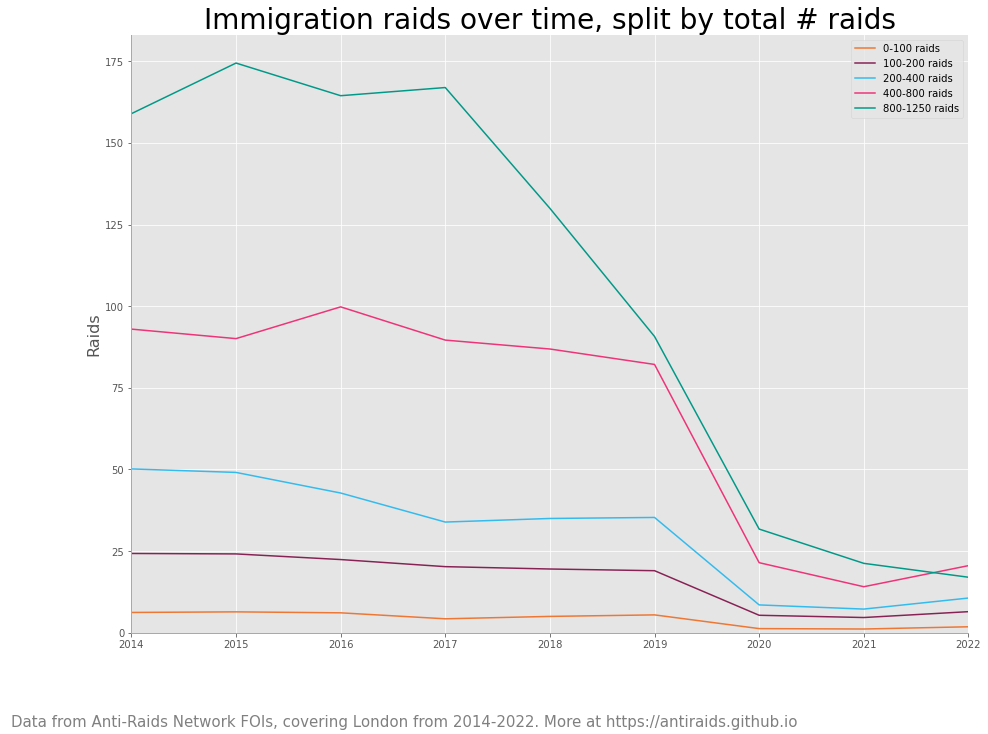

In [32]:
fig_slc, ax_slc = plt.subplots()
ax_slc.set_xticks(range(first_yr, last_yr+1))
ax_slc.set_ylabel('Raids')
ax_slc.set_title("Immigration raids over time, split by total # raids")

cmap = ['#EE7733', '#882255', '#33BBEE', '#EE3377', '#009988']

buckets = [0, 100, 200, 400, 800, 1250]
for i, c in enumerate(cmap):
    slc = raid_total[buckets[i] <= raid_total['Count']]
    slc = slc[slc['Count'] < buckets[i+1]]
    slc_by_yr = raids[raids['Postcode'].isin(slc.index)].groupby('Year').mean()
    ax_slc.plot(slc_by_yr, label=f'{buckets[i]}-{buckets[i+1]} raids', color=c)
ax_slc.set_ylim(0)
ax_slc.set_xlim(first_yr, last_yr)
ax_slc.legend()

plt.annotate(watermark_str, (0.01, 0.01), xycoords='figure fraction', color='grey', fontsize=15)
plt.savefig('Outputs\\Raids_change_grouped.png')

# For future

~~**comparison** Interactive line plots, to avoid cognitive overhead from small multiples with non-analysts~~ (see the `interactive_line.ipynb` file)

**comparison** Where are there local anti-raids groups? Where _should_ there be anti-raids groups?

**factoid** What extra detail can we get? (e.g. past FOI data with cop accompaniment, W FOI data with breakdown)